In [66]:
# Add at the top of the notebook
import cProfile
import pstats

# Modify the simulation loop:
profiler = cProfile.Profile()
profiler.enable()


In [77]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from dataclasses import dataclass, field
from typing import List, Optional, Tuple
import numpy as np


crater_dtype = np.dtype([
('radius', 'f4'),          # float32 for crater radius
('y_position', 'f4'),      # float32 for y-axis position
('time_formed', 'i4'),     # int32 for timestamp
('depth', 'f4'),           # float32 for crater depth
])
    
@dataclass
class EDMState:
    # Time tracking
    time: int = 0 # Current time from start of simulation
    time_since_servo: int = 0 # Time since last servo action
    time_since_open_voltage: int = 0  # Time since last voltage was applied
    time_since_spark_ignition: int = 0 # Time since last spark was ignited
    time_since_spark_end: int = 0 # Time since last spark ended
    
    
    # Electrical state variables
    voltage: Optional[float] = None
    current: Optional[float] = None
    
    # Generator control state variables
    target_voltage: Optional[float] = None
    peak_current: Optional[float] = None
    OFF_time: Optional[float] = None
    ON_time: Optional[float] = None

    # Workpiece state variables
    
    workpiece_position: float = 0 # Current position of the workpiece
    
    # Wire state variables
    wire_position: float = 0.0 # Current position of the wire
    wire_velocity: float = 0.0 # Current velocity of the wire
    wire_unwinding_velocity = 0.2 # Unwinding velocity of the wire in micrometers per microsecond (microns/μs -- mm/ms .. m/s)
    wire_temperature: np.ndarray = field(default_factory=lambda: np.array([], dtype=np.float32))
    time_in_critical_temp: int = 0
    
    
    # Spark state variables
    
    # Tuple to track current spark status (state, y-location, duration)
    # state: 0=No event, 1=Spark formation, -1=Short circuit, -2=Rest period
    # y_location: Position along wire length where spark is occurring (None if no spark)
    # duration: How many timesteps the current spark state has existed
    
    spark_status: List[Optional[float]] = field(default_factory=lambda: [0, None, 0])

    
    # Dielectric state variables
    
    dielectric_conductivity: float = 0.0 # Conductivity of the dielectric
    dielectric_temperature: float = 0.0 # Temperature of the dielectric
    debris_concentration: float = 0.0 # Concentration of debris in the dielectric
    dielectric_flow_rate: float = 0.0 # Flow rate of the dielectric
    ionized_channel: Optional[Tuple[float, int]] = None # (y_location, time_remaining) or None
    
    # Servo state variables
    
    target_delta: float = 0.0 # Target change in position for the servo in the linear axis. This is the main servo control signal.
    
    # Process state
    is_wire_broken: bool = False
    is_wire_colliding: bool = False
    is_target_distance_reached: bool = False


class EDMModule:
    """Base class for all EDM simulation modules"""
    def __init__(self, env):
        self.env = env

    def update(self, state: EDMState) -> None:
        pass
    
class IgnitionModule(EDMModule):
    def __init__(self, env):
        super().__init__(env)
        self.lambda_cache = {}  # Cache for lambda values
        
    def update(self, state: EDMState) -> None:
        
        # First, unpack the generator control state
        target_voltage = state.target_voltage
        peak_current = state.peak_current
        
        ON_time = state.ON_time if state.ON_time is not None else 3  # Default to 3
        OFF_time = state.OFF_time if state.OFF_time is not None else 80  # Default to 80
        
        # Check for physical short circuit (wire touching workpiece)
        if state.wire_position >= state.workpiece_position:
            state.spark_status = [-1, None, 0]
            state.voltage = 0
            state.current = state.peak_current
            return

        # Check spark status in the previous timestep
        spark_state, spark_location, spark_duration = state.spark_status
        
        # # Check for ionized channel short circuit
        # if state.ionized_channel is not None:
        #     y_loc, time_remaining = state.ionized_channel
        #     # Treat ionized channel as a short circuit
        #     state.spark_status = [-1, y_loc, 0]
        #     state.voltage = 0
        #     state.current = state.peak_current
        #     return
            
        # # Check for debris-induced short circuit
        # if self.env.np_random.random() < state.debris_concentration * 0.1: # Scale factor of 0.1 for probability
        #     state.spark_status = [-1, None, 0]
        #     state.voltage = 0 
        #     state.current = state.peak_current
        #     return
        
        
        # Suppose spark is already present, maintain it until current is cut
        if spark_state == 1: # If spark is happening
            state.spark_status = [1, spark_location, spark_duration + 1] # Increment counter
            if state.spark_status[2] >= ON_time: # End of spark duration
                state.spark_status[0] = -2 # Start rest period
                state.current = 0
                state.voltage = 0
            else:
                state.current = peak_current
                state.voltage = target_voltage * 0.3
            return
        
        if spark_state == -2: # If in rest period
            state.spark_status = [-2, None, spark_duration + 1]
            if state.spark_status[2] >= OFF_time + ON_time:  # End of rest period
                state.spark_status = [0, None, 0]
                state.voltage = target_voltage
                state.current = 0
            return
        
        if spark_state == 0: # No spark happening and not in rest period
            state.voltage = target_voltage
            state.current = 0
            # Calculate probability of new spark formation
            p_ignition = self._get_spark_conditional_probability(state)
    
            # Sample from probability distribution
            if self.env.np_random.random() < p_ignition:
                # Ignition occurs - randomly choose location along wire height
                
                spark_location = self.env.np_random.uniform(0, self.env.workpiece_height)

                state.spark_status = [1, spark_location, 0]
                state.voltage = state.target_voltage * 0.3  # Voltage drops during discharge
                state.current = state.peak_current
            else:
                # No ignition
                state.spark_status = [0, None, 0]
                state.voltage = state.target_voltage
                state.current = 0
    
    def _get_spark_conditional_probability(self, state):
        """ Calculate the conditional probability of sparking at a given microsecond,
        given that it has not sparked yet since the last voltage rise."""

        # In the case of the exponential distribution, the conditional
        # probability is just lambda
        return self._get_lambda(state)
    
    def _get_lambda(self, state):
        gap_distance = abs(state.workpiece_position - state.wire_position)
        # Check cache first
        if gap_distance in self.lambda_cache:
            return self.lambda_cache[gap_distance]
        # Calculate new lambda value and cache it
        lambda_value = np.log(2)/(0.48*gap_distance*gap_distance - 3.69*gap_distance + 14.05)
        self.lambda_cache[gap_distance] = lambda_value
        
        return lambda_value

# Add other modules similarly
class MaterialRemovalModule(EDMModule):
    # TODO: Add crater formation and removal rate based on spark energy
    def update(self, state):
        # Only remove material if there is an active spark that just started
        if state.spark_status[0] == 1 and state.spark_status[2] == 0:
            # Remove a constant amount of material by moving the workpiece position
            # away from the wire by a small fixed increment
            removal_rate = 0.05  # mm per spark
            state.workpiece_position += removal_rate

class DielectricModule(EDMModule):
    def __init__(self, env):
        super().__init__(env)
        # Dielectric state variables
        self.dielectric_temp = 293.15  # Dielectric temperature in K
        self.debris_concentration = 0.0  # Debris concentration (0-1) 
        self.flow_rate = 1.0  # Normalized flow rate (0-1)
        self.ionized_channel = None  # (y_location, time_remaining) or None
        
        # Model parameters
        self.beta = 1e-3  # Debris concentration increase per mm^3 of crater volume
        self.gamma = 5e-4  # Base debris decay rate per microsecond at flow_rate=1
        self.tau_deionization = 6  # Deionization time in microseconds
        
    def update(self, state):
        # Update dielectric temperature
        state.dielectric_temperature = self.dielectric_temp
        
        # Handle debris concentration
        # Add debris if there was a spark that just started
        if state.spark_status[0] == 1 and state.spark_status[2] == 0:
            # Get crater volume from material removal module (placeholder value for now)
            crater_volume = 0.1  # mm^3
            self.debris_concentration = min(1.0, 
                self.debris_concentration + self.beta * crater_volume)
            
            # Create new ionized channel
            self.ionized_channel = (state.spark_status[1], self.tau_deionization)
            
        # Update ionized channel state
        if self.ionized_channel:
            y_loc, time_remaining = self.ionized_channel
            if time_remaining > 0:
                self.ionized_channel = (y_loc, time_remaining - 1)
            else:
                self.ionized_channel = None
                
        # Clear debris based on flow rate (exponential decay)
        self.debris_concentration *= (1 - self.gamma * self.flow_rate)
        self.debris_concentration = max(0.0, self.debris_concentration)
        
        # Update state variables
        state.debris_concentration = self.debris_concentration
        state.flow_rate = self.flow_rate
        state.ionized_channel = self.ionized_channel
        
        

class WireModule(EDMModule):
    def __init__(self, env):
        super().__init__(env)
        
        # Thermal model parameters
        self.segment_length = 0.2  # Fixed segment length (0.1 mm = 100 microns)
        self.wire_length = env.workpiece_height  # mm
        self.n_segments = int(self.wire_length / self.segment_length)  # Number of segments based on fixed length
        self.wire_radius = env.wire_diameter / 2  # mm
        
        # Initialize the wire temperature array with the correct number of segments
        if len(env.state.wire_temperature) == 0:  # Only initialize if not already set
            env.state.wire_temperature = np.full(self.n_segments, 293.15, dtype=np.float32)
        # Material properties (brass example)
        self.rho = 8400  # kg/m³ density
        self.cp = 377  # J/kg·K specific heat
        self.k = 120  # W/m·K thermal conductivity
        self.melting_point = 1180  # K (907°C)
        self.rho_electrical = 6.4e-8  # Ohm·m at 20°C
        self.alpha_resistivity = 0.0039  # Temperature coefficient
        
        # Heat transfer parameters
        self.h_convection = 3000  # W/m²K convection coefficient
        self.eta_plasma = 0.1  # Plasma energy transfer efficiency
        
        # Break detection parameters
        self.critical_temp = 100  # K - sustained temperature threshold
        self.critical_duration = 1e6  # μs (1s) at critical_temp
        # Precompute constant terms during initialization
        self.delta_y = self.segment_length * 1e-3  # Convert to meters once
        self.S_wire = np.pi * (self.wire_radius * 1e-3)**2  # Cross-sectional area
        self.A_wire = 2 * np.pi * (self.wire_radius * 1e-3) * self.delta_y  # Surface area
        self.conduction_coeff = (self.k * self.S_wire) / self.delta_y
        
        # Preallocate arrays for thermal calculations
        self.T_prev = np.empty(self.n_segments, dtype=np.float32)
        self.T_next = np.empty(self.n_segments, dtype=np.float32)
        self.q_plasma = np.zeros(self.n_segments, dtype=np.float32)
        self.q_joule = np.zeros(self.n_segments, dtype=np.float32)

    def update(self, state: EDMState) -> None:
        if state.is_wire_broken:
            return

        T = state.wire_temperature
        current = state.current if state.current is not None else 0.0
        
        # Optimized boundary handling using slicing instead of roll
        self.T_prev[1:] = T[:-1]
        self.T_prev[0] = 293.15
        self.T_next[:-1] = T[1:]
        self.T_next[-1] = 293.15

        # Vectorized plasma heating with simplified index calculation
        if state.spark_status[0] == 1 and state.spark_status[1] is not None:
            spark_y = state.spark_status[1]
            segment_idx = np.clip(int(spark_y // self.segment_length), 0, len(T)-1)
            self.q_plasma[segment_idx] = self.eta_plasma * state.voltage * current
        else:
            self.q_plasma.fill(0)

        # Optimized joule heating calculation
        np.copyto(self.q_joule, (current**2 * self.rho_electrical * 
                 (1 + self.alpha_resistivity * (T - 293.15)) * self.delta_y) / self.S_wire)
        self.q_joule *= 0.5

        # Vectorized thermal terms using precomputed coefficients
        q_cond = self.conduction_coeff * (self.T_prev - 2*T + self.T_next)
        
        # Optimized convection cooling (remove redundant clip)
        h_effective = self.h_convection * (1 + 0.5 * state.wire_unwinding_velocity)
        q_conv = h_effective * self.A_wire * (T - state.dielectric_temperature)
        
        # Simplified transport cooling (remove unnecessary clip)
        safe_velocity = state.wire_unwinding_velocity
        q_transport = (self.rho * self.cp * safe_velocity * 1e-3 * 
                      self.S_wire * (self.T_next - T)) / self.delta_y

        # Combined temperature update
        denominator = self.rho * self.cp * self.S_wire * self.delta_y
        dT_dt = (self.q_plasma + self.q_joule + q_cond - q_conv + q_transport) / denominator
        new_temps = T + dT_dt * 1e-6
        
        # In-place updates to avoid array copies
        state.wire_temperature[:] = new_temps
        state.wire_average_temperature = np.mean(state.wire_temperature)

        # Sustained temperature detection
        critical_mask = new_temps > self.critical_temp
        state.time_in_critical_temp = np.where(critical_mask, state.time_in_critical_temp + 1, 0)
        if np.any(state.time_in_critical_temp > self.critical_duration):
            state.is_wire_broken = True
            print("Wire broken: Sustained critical temperature!")

    def _is_spark_in_segment(self, segment_idx, spark_y):
        """Check if spark y-position falls within specified segment"""
        if spark_y is None:
            return False
        segment_start = segment_idx * self.segment_length
        segment_end = (segment_idx + 1) * self.segment_length
        return segment_start <= spark_y < segment_end

class MechanicsModule(EDMModule):
    def update(self, state):
        # For the moment leave blank
        pass



class WireEDMEnv(gym.Env):    
    metadata = {"render_modes": ["human"], "render_fps": 300}
    
    def __init__(self, render_mode=None):
        self.render_mode = render_mode
        # Simulation parameters
        ## Internal timestep parameters
        self.dt = 1 # Base timestep (1μs)
        self.servo_interval = 1000 # Servo interval (1ms)
        
        ## Process configuration
        ### Workpiece physical properties
        self.workpiece_height = 10 # Height of workpiece (mm)
        self.workpiece_material = 'steel' # Material of workpiece
        #...
        
        ### Wire physical properties
        self.wire_material = 'brass'
        self.wire_diameter = 0.25 # Diameter of wire (mm)
        #...
        
        ### Dielectric physical properties
        self.dielectric_material = 'deionized water'
        
        self.state = EDMState() # Initialize state of the simulation
        
        self.ignition_module = IgnitionModule(self)
        self.material_removal_module = MaterialRemovalModule(self)
        self.dielectric_module = DielectricModule(self)
        self.wire_module = WireModule(self)
        self.mechanics_module = MechanicsModule(self)
        
        self.action_space = spaces.Dict({
            'servo': spaces.Box(
                low=np.array([-1.0]),
                high=np.array([1.0]),
                dtype=np.float32
            ),
            'generator_control': spaces.Dict({
                'target_voltage': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([200.0]),  # Placeholder max voltage
                    dtype=np.float32
                ),
                'peak_current': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([100.0]),  # Placeholder max current
                    dtype=np.float32
                ),
                 'ON_time': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([5.0]),  # Placeholder max on time
                    dtype=np.float32
                ),
                 'OFF_time': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([100.0]),  # Placeholder max off time
                    dtype=np.float32
                )
            })
        })
    
    def _check_termination(self):
        # Check for wire breakage
        if self.state.wire_position > self.workpiece_height:
            self.state.is_wire_broken = True
            return True
        
        # Check for target distance reached
        if self.state.workpiece_position >= self.state.target_delta:
            self.state.is_target_distance_reached = True
            return True
        
        return False
    
    def _get_obs(self):
        return None
        
    def _calculate_reward(self):
        return 0
    
    def step(self, action):
        # Track if this is a control step (every 1ms / 1000μs)
        is_control_step = self.state.time_since_servo >= self.servo_interval
        
        # Only process actions on control steps
        if is_control_step:
            self.state.target_delta = action['servo'][0]
            self.state.target_voltage = action['generator_control']['target_voltage'][0]
            self.state.peak_current = action['generator_control']['peak_current'][0]
            self.state.ON_time = action['generator_control']['ON_time'][0]  # Add these two lines
            self.state.OFF_time = action['generator_control']['OFF_time'][0]
            self.state.time_since_servo = 0  # Reset timer
        
        # Sequential process updates
        self.ignition_module.update(self.state)
        self.material_removal_module.update(self.state)
        self.dielectric_module.update(self.state)
        self.wire_module.update(self.state)
        if self.state.is_wire_broken:
            # If the wire is broken, return immediately
            return None, 0, True, False, {'wire_broken': True}
        self.mechanics_module.update(self.state)
        
        # Update time trackers
        self.state.time += self.dt
        self.state.time_since_servo += self.dt
        self.state.time_since_open_voltage += self.dt
        
        if self.state.spark_status[0] == 1:
            self.state.time_since_spark_ignition += self.dt
            self.state.time_since_spark_end = 0
        else:
            self.state.time_since_spark_end += self.dt
            self.state.time_since_spark_ignition = 0
        
        # Only return meaningful observations and calculate rewards on control steps
        if is_control_step:
            observation = self._get_obs()
            reward = self._calculate_reward()
            self.previous_target_current = self.state.peak_current
        else:
            observation = None
            reward = 0
        
        terminated = self._check_termination()
        truncated = False
        
        info = {
            'wire_broken': self.state.is_wire_broken,
            'target_reached': self.state.is_target_distance_reached,
            'spark_status': self.state.spark_status[0],
            'time': self.state.time,
            'is_control_step': is_control_step
        }
        
        return observation, reward, terminated, truncated, info


Simulation took 0.7826941013336182 seconds
Thu Jan 30 22:31:20 2025    edm_profile.prof

         859595 function calls in 1.098 seconds

   Ordered by: cumulative time
   List reduced from 120 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    0.000    0.000    1.134    0.142 interactiveshell.py:3541(run_code)
        8    0.000    0.000    1.134    0.142 {built-in method builtins.exec}
    20000    0.073    0.000    1.060    0.000 204922526.py:434(step)
    20000    0.503    0.000    0.880    0.000 204922526.py:284(update)
    20000    0.019    0.000    0.194    0.000 fromnumeric.py:3783(mean)
    20000    0.086    0.000    0.175    0.000 _methods.py:119(_mean)
    20344    0.017    0.000    0.088    0.000 fromnumeric.py:2250(clip)
    20035    0.013    0.000    0.075    0.000 fromnumeric.py:2496(any)
    20000    0.045    0.000    0.073    0.000 204922526.py:89(update)
    20344    0.014    0.000    0.071    0.000 from

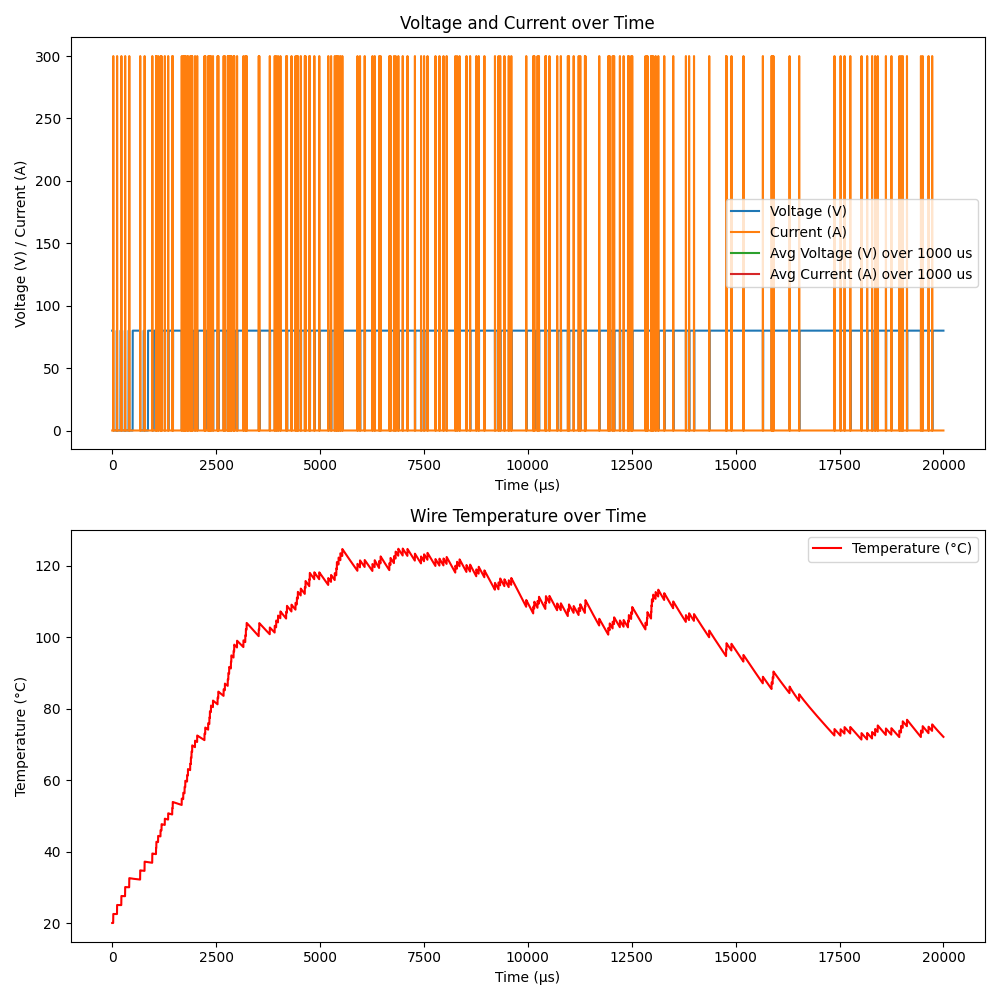

In [78]:
import matplotlib.pyplot as plt
import time
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter

%matplotlib widget  
env = WireEDMEnv()
env.state.workpiece_position = 10
env.state.wire_position = 0
env.state.target_voltage = 80
env.state.peak_current = 300
env.state.OFF_time = 80

voltage_history = []
current_history = []
time_history = []
temperature_history = []
wire_temperature_evolution = []

start_time = time.time()
for i in range(20000): # 1 seconds of simulation at 1us timesteps
    action = {
        'servo': np.array([0.0], dtype=np.float32),
        'generator_control': {
            'target_voltage': np.array([80.0], dtype=np.float32),
            'peak_current': np.array([300.0], dtype=np.float32),
            'ON_time': np.array([2.0], dtype=np.float32),
            'OFF_time': np.array([5.0], dtype=np.float32)
        }
    }
    env.step(action)
    voltage_history.append(env.state.voltage)
    current_history.append(env.state.current)
    time_history.append(env.state.time)
    temperature_history.append(env.state.wire_average_temperature)
    wire_temperature_evolution.append(env.state.wire_temperature.copy())
end_time = time.time()
print(f"Simulation took {end_time - start_time} seconds")

profiler.disable()
profiler.dump_stats('edm_profile.prof')

# Print profiling results sorted by cumulative time
stats = pstats.Stats('edm_profile.prof')
stats.strip_dirs().sort_stats('cumtime').print_stats(20)

# Calculate average voltage and current over 1000 us windows
window_size = 10000
avg_voltage_history = []
avg_current_history = []
avg_time_history = []

for i in range(0, len(voltage_history) - window_size, window_size):
    avg_voltage_history.append(np.mean(voltage_history[i:i+window_size]))
    avg_current_history.append(np.mean(current_history[i:i+window_size]))
    avg_time_history.append(np.mean(time_history[i:i+window_size]))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot voltage and current on first subplot
ax1.plot(time_history, voltage_history, label="Voltage (V)")
ax1.plot(time_history, current_history, label="Current (A)")
ax1.plot(avg_time_history, avg_voltage_history, label="Avg Voltage (V) over 1000 us")
ax1.plot(avg_time_history, avg_current_history, label="Avg Current (A) over 1000 us")
ax1.set_xlabel("Time (μs)")
ax1.set_ylabel("Voltage (V) / Current (A)")
ax1.set_title("Voltage and Current over Time")
ax1.legend()

# Plot temperature on second subplot
ax2.plot(time_history, [temp - 273.15 for temp in temperature_history], label="Temperature (°C)", color='red')
ax2.set_xlabel("Time (μs)")
ax2.set_ylabel("Temperature (°C)")
ax2.set_title("Wire Temperature over Time")
ax2.legend()

plt.tight_layout()
plt.show()

# 

In [79]:
# Create a new figure for the temperature evolution animation
fig_anim, ax_anim = plt.subplots(figsize=(4, 10))  # Taller aspect ratio for vertical orientation

# Generate position array and create segment coordinates
segment_length = 0.2  # Should match WireModule's segment_length
n_segments = len(env.state.wire_temperature)
wire_positions = np.linspace(0, n_segments*segment_length, n_segments)

# Create custom colormap (blue at 20°C, red at 80°C)
from matplotlib.colors import LinearSegmentedColormap
colors = [
    (0, 'black'),    # 0°C
    (0.2, 'blue'),      # 20°C
    (0.8, 'red'),       # 80°C
    (1, 'yellow')      # 100°C
]
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
norm = plt.Normalize(vmin=0, vmax=100)  # Temperature range in °C

# Create initial vertical scatter plot
scat = ax_anim.scatter(
    np.zeros_like(wire_positions),  # X-position fixed at 0 for vertical line
    wire_positions,                 # Y-position now represents wire length
    c=wire_temperature_evolution[0] - 273.15,
    cmap=cmap,
    norm=norm,
    s=400,  # Increased from 40 to 400 for much larger squares
    edgecolor='k',
    linewidth=0.5,
    marker='s'  # Square markers for better vertical alignment
)

# Add colorbar
cbar = plt.colorbar(scat, ax=ax_anim)
cbar.set_label('Temperature (°C)')

# Format plot for vertical orientation
ax_anim.set_ylabel("Wire Position (mm)")
ax_anim.set_xlabel("")
ax_anim.set_title("Wire Temperature Distribution Evolution")
ax_anim.set_xticks([])  # Hide X-axis
ax_anim.set_ylim(0, n_segments*segment_length)
ax_anim.set_xlim(-0.2, 0.2)  # Increased range to accommodate larger squares

# Define the update function for the animation
def update(frame):
    # Convert temperatures to Celsius and update colors
    actual_frame = frame * 20  # Skip 200 frames at a time
    scat.set_array(wire_temperature_evolution[actual_frame] - 273.15)
    
    # Update title with current frame/time
    ax_anim.set_title(f"Wire Temperature Distribution - Time: {time_history[actual_frame]}μs")
    return scat,

# Create the animation with fewer frames (every 10th frame)
anim = FuncAnimation(fig_anim, update, frames=len(wire_temperature_evolution)//20, 
                    interval=50, blit=True)

# Save the animation as a GIF
writer = PillowWriter(fps=20)
anim.save('wire_temperature_heatmap.gif', writer=writer)

plt.close(fig_anim)

In [83]:
# Separate the simulation from visualization
import cProfile
import pstats

# Profile only the simulation loop
profiler = cProfile.Profile()
profiler.enable()

env = WireEDMEnv()
env.state.workpiece_position = 10
env.state.wire_position = 0
env.state.target_voltage = 80
env.state.peak_current = 300
env.state.OFF_time = 80

# Run simulation without storing visualization data
for i in range(20000):
    action = {
        'servo': np.array([0.0], dtype=np.float32),
        'generator_control': {
            'target_voltage': np.array([80.0], dtype=np.float32),
            'peak_current': np.array([300.0], dtype=np.float32),
            'ON_time': np.array([2.0], dtype=np.float32),
            'OFF_time': np.array([5.0], dtype=np.float32)
        }
    }
    env.step(action)

profiler.disable()

# Print more detailed stats
stats = pstats.Stats(profiler)
stats.sort_stats('cumtime')  # Sort by cumulative time
# Print top 20 functions, excluding standard library
stats.print_stats('^(?!{lib}).*$'.format(lib='lib|site-packages'), 20)

         739767 function calls in 0.983 seconds

   Ordered by: cumulative time
   List reduced from 120 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    0.000    0.000    1.017    0.127 c:\Users\GonzalezSanchezEduar\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\IPython\core\interactiveshell.py:3541(run_code)
        8    0.000    0.000    1.017    0.127 {built-in method builtins.exec}
    20000    0.066    0.000    0.946    0.000 C:\Users\GonzalezSanchezEduar\AppData\Local\Temp\ipykernel_15892\3883522501.py:434(step)
    20000    0.485    0.000    0.771    0.000 C:\Users\GonzalezSanchezEduar\AppData\Local\Temp\ipykernel_15892\3883522501.py:284(update)
    20000    0.021    0.000    0.191    0.000 c:\Users\GonzalezSanchezEduar\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\numpy\_core\fromnumeric.py:3783(mean)
    20000    0.084    0.000    0.171    0.000 c:\Users\GonzalezSanchezEduar\.pyenv\pyenv-win\versions\

In [84]:
# First, install line_profiler if you haven't already
!pip install line_profiler

# Load the line_profiler extension
%load_ext line_profiler

# Create a new instance for testing
env = WireEDMEnv()
env.state.workpiece_position = 10
env.state.wire_position = 0
env.state.target_voltage = 80
env.state.peak_current = 300
env.state.OFF_time = 80

# Profile the wire module's update method
%lprun -f env.wire_module.update -T wire_profile.txt env.wire_module.update(env.state)

# For multiple iterations:
def run_wire_update():
    for _ in range(1000):  # Reduce from 20000 to get cleaner output
        env.wire_module.update(env.state)

%lprun -f env.wire_module.update run_wire_update()

     -------------------------------------- 128.9/128.9 kB 3.8 MB/s eta 0:00:00

*** Profile printout saved to text file 'wire_profile.txt'. 



[notice] A new release of pip available: 22.3 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Timer unit: 1e-07 s

Total time: 0.0393439 s

Could not find file C:\Users\GonzalezSanchezEduar\AppData\Local\Temp\ipykernel_15892\3883522501.py
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
   284                                           
   285      1000       1666.0      1.7      0.4  
   286                                           
   287                                           
   288      1000       1521.0      1.5      0.4  
   289      1000       2067.0      2.1      0.5  
   290                                           
   291                                           
   292      1000       5742.0      5.7      1.5  
   293      1000       3310.0      3.3      0.8  
   294      1000       4714.0      4.7      1.2  
   295      1000       2085.0      2.1      0.5  
   296                                           

In [85]:
# First, let's print the WireModule's update method
import inspect

print("Wire Module Update Method Contents:")
print(inspect.getsource(env.wire_module.update))

# Now run the profiler
%load_ext line_profiler

def run_wire_update():
    for _ in range(1000):
        env.wire_module.update(env.state)

%lprun -f env.wire_module.update run_wire_update()

Wire Module Update Method Contents:
    def update(self, state: EDMState) -> None:
        if state.is_wire_broken:
            return

        T = state.wire_temperature
        current = state.current if state.current is not None else 0.0
        
        # Optimized boundary handling using slicing instead of roll
        self.T_prev[1:] = T[:-1]
        self.T_prev[0] = 293.15
        self.T_next[:-1] = T[1:]
        self.T_next[-1] = 293.15

        # Vectorized plasma heating with simplified index calculation
        if state.spark_status[0] == 1 and state.spark_status[1] is not None:
            spark_y = state.spark_status[1]
            segment_idx = np.clip(int(spark_y // self.segment_length), 0, len(T)-1)
            self.q_plasma[segment_idx] = self.eta_plasma * state.voltage * current
        else:
            self.q_plasma.fill(0)

        # Optimized joule heating calculation
        np.copyto(self.q_joule, (current**2 * self.rho_electrical * 
                 (1 + self.a

Timer unit: 1e-07 s

Total time: 0.0372953 s

Could not find file C:\Users\GonzalezSanchezEduar\AppData\Local\Temp\ipykernel_15892\3883522501.py
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
   284                                           
   285      1000       1827.0      1.8      0.5  
   286                                           
   287                                           
   288      1000       1444.0      1.4      0.4  
   289      1000       1852.0      1.9      0.5  
   290                                           
   291                                           
   292      1000       5934.0      5.9      1.6  
   293      1000       2340.0      2.3      0.6  
   294      1000       4604.0      4.6      1.2  
   295      1000       2037.0      2.0      0.5  
   296                                           